# Step B - Multiple Instance Detection

- Baraghini Nicholas
- Marini Luca

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

In [2]:
sift = cv2.xfeatures2d.SIFT_create()

In [3]:
def Matching(Model_Descriptors, Scene_Descriptors, Treshold = 0.45, k=2):
    FLANN_INDEX_KDTREE = 1

    # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    # Matching and finding the 2 closest elements for each query descriptor.
    matches = flann.knnMatch(Model_Descriptors, Scene_Descriptors, k)
    #defining an array containing all the matches that results to be considered "good" matches applying a certain treshold 
    good = []
    for m,n in matches:
        if m.distance < Treshold * n.distance: #  if m.distance/n.distance < Threshold:
            good.append(m)
            
    return good

In [4]:
#Definition of the function which find the model center and stores it in the dictionary "model_images_features"
def InstanceCenter(model_img,model_images_features, i, CENTER_INDEX=3):
    height, width, channels = model_img.shape
    v = int(height/2) # vertical coordinate of the image center
    h = int(width/2)  # horizontal position of the image center
    G = np.array([h, v]) # Defnition of the position center of the model
    if len( model_images_features[i])<=CENTER_INDEX:
        model_images_features[i].append(G) # Updating the model feature dictionary appending the information of the center
    else :
        #in the case G is already present in the model feature dictionary then update the G alreary there
        model_images_features[i][CENTER_INDEX] = G

In [5]:
NUM_OF_MODELS = 27

IMAGE_INDEX      = 0
KEYPOINT_INDEX   = 1
DESCRIPTOR_INDEX = 2
CENTER_INDEX     = 3
V_INDEX          = 4
TRESHOLD_INDEX = 5

# Dictionary that contains the image, all keypoints and descriptors for each model images
model_images_features = {}
mean_of_model_intensities_r_g_b = {}

for i in range(NUM_OF_MODELS):
    model_img = cv2.imread('./models/{}.jpg'.format(i), cv2.COLOR_BGR2RGB)
    kp_model = sift.detect(model_img)
    kp_model, des_model = sift.compute(model_img, kp_model)
    model_images_features[i] = [model_img, kp_model, des_model]
    
    b,g,r = cv2.split(model_images_features[i][IMAGE_INDEX])
    # save the mean of the intensities (divided per channel) for every model image
    mean_of_model_intensities_r_g_b[i] = [np.mean(r), np.mean(g), np.mean(b)]
    #Find or update the center of the model image information collected in the model features dictionary
    InstanceCenter(model_img,model_images_features, i, CENTER_INDEX=3) 


In [6]:
def distance_2_points(A, B):
    return math.sqrt( np.power(A[0] - B[0], 2) +  np.power(A[1] - B[1], 2))

In [7]:
scenes_to_test = [1, 2, 3, 4, 5]

# Dictionary that contains the image, all keypoints and descriptors for each easy scene image
m_scenes_images_features = {}

for i in scenes_to_test:
    scene_img = cv2.imread('./scenes/m{}.png'.format(i), cv2.COLOR_BGR2RGB)
    kp_scene = sift.detect(scene_img)
    kp_scene, des_scene = sift.compute(scene_img, kp_scene)
    m_scenes_images_features[i] = [scene_img, kp_scene, des_scene]

In [8]:
# This function create or update the model_images_features dictionary which contains all the relevant features of the 
# each model image, with a list containing all the voting vectors computed for each good match between the keypoints of 
# the model and the scene image

def VotingVectors(Good_Matches,model_images_features, i):
    # getting the coordinates of the center of the i-th model, G
    G_x = model_images_features[i][CENTER_INDEX][0]
    G_y = model_images_features[i][CENTER_INDEX][1]
        
    #Initializing the vector V 
    V = []
    
    for m in Good_Matches:
        # getting the coordinates of the m-th keypoint in the i-th model
        Kp_x = int(model_images_features[i][KEYPOINT_INDEX][m.queryIdx].pt[0])
        Kp_y = int(model_images_features[i][KEYPOINT_INDEX][m.queryIdx].pt[1])
            
        #defining the point V = Kp[m,i] - G[i] 
        vx = Kp_x - G_x
        vy = Kp_y - G_y
            
        #computing the slope of the direction aligning the center point G with the m-th keypoint
        #in the case V = (0,0) it means basically that the point G[i] and Kp[m,i] are coincident and so the slope will not exist;
        # Or another case where the slope does not exist is if the the G[i] and the Kp[m,i] are aligned in a vertical line;
        # In such cases the slope variable can be considered as an array containing two informations, the fisrt information is the 
        # actual value of the slope, while the second information encloses if the slope exists or not (1,0 respectively)
        if (np.abs(vx) + np.abs(vy)) == 0 :
            slope = [0, 0]
        elif vy == 0 :
            slope = [1, 0]
        else:
            slope = [vx/vy, 1]
            
        #creating an array containing the V coordinates and the slope of the line 
        v = [vx, vy, slope]
        V.append(v)

    if len( model_images_features[i]) <= V_INDEX :
        # Updating the model feature dictionary appending the information of the vector V
        model_images_features[i].append(V) 
    else: 
        #in the case V is already present in the model feature dictionary then update the V alreary there
        model_images_features[i][V_INDEX] = V

    return V    

In [9]:
def KeyPoints_Comparison(models_images_features,scenes_images_features, Good_Matches):
    model_kps_size = [] #list containing the size of each matched keypoint belonging to the model
    scene_kps_size = [] #list containing the size of each matched keypoint belonging to the scene
    ratio_of_sizes = [] #list containing the ratio between the sizes of the same keypoint found in the model and in the scene, representing the change in dimensions
    
    model_kps_angle = [] #list containing the angle of each matched keypoint belonging to the model
    scene_kps_angle = [] #list containing the angle of each matched keypoint belonging to the scene
    relative_angles = [] #list containing the angle between the model and the scene, representing rotation occuring between model and scene instance
    
    for o in Good_Matches:
        #Defining two vectors respectively containing the size of the keypoints belonging to the model and 
        #to the scene
        M_kp_size = np.float32(models_images_features[i][KEYPOINT_INDEX][o.queryIdx].size)
        S_kp_size = np.float32(scenes_images_features[j][KEYPOINT_INDEX][o.trainIdx].size)
        model_kps_size.append(M_kp_size)
        scene_kps_size.append(S_kp_size)
        #Defining two vectors respectively containing the angle of the keypoints belonging to the model and 
        #to the scene        
        M_kp_angle = np.float32(models_images_features[i][KEYPOINT_INDEX][o.queryIdx].angle)
        S_kp_angle = np.float32(scenes_images_features[j][KEYPOINT_INDEX][o.trainIdx].angle)
        model_kps_angle.append(M_kp_angle)
        scene_kps_angle.append(S_kp_angle)

        #defining the change in dimensions between the keypoints of the model compared to the same ones found 
        #in the scene side
        ratio_of_sizes.append(M_kp_size/S_kp_size)
        
        #defining the change in dimensions between the keypoints of the model compared to the same ones found 
        #in the scene side
        relative_angles.append(M_kp_angle-S_kp_angle)       

    #computation of the mean scale factor
    if len(ratio_of_sizes) : 
        Mean_Scale_Factor = (sum(ratio_of_sizes))/len(ratio_of_sizes)
    else: 
        # Mean_Scale_Factor = 0
        Mean_Scale_Factor = 3.5
    #computation of the mean relative angle
    if len(relative_angles) :
        Mean_Relative_Angle = (sum(relative_angles))/len(relative_angles)
    else: 
        Mean_Relative_Angle = 0
        
    return Mean_Scale_Factor, Mean_Relative_Angle

In [10]:
def Accumulator_Array(ACC_ARRAY_CELL_DIMENSION_1, ACC_ARRAY_CELL_DIMENSION_2, Scene_img, Model_img, 
                      models_images_features, scenes_images_features, Good_Matches, V, i, j, KEYPOINT_INDEX = 1):
    #Accumulator dimensions
    Acc_dim = (int(scenes_images_features[j][0].shape[0] / ACC_ARRAY_CELL_DIMENSION_2), 
               int(scenes_images_features[j][0].shape[1] / ACC_ARRAY_CELL_DIMENSION_1))
    Accumulator_Array_Points = {}
    #Accumulator array as a matrix of zeroes
    Accumulator_Array = np.zeros(Acc_dim)
    #print(Accumulator_Array.shape)
    #extracting all the keypoints of the scene resulting in good matches
    scene_pts = np.float32([scenes_images_features[j][KEYPOINT_INDEX][m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    #computing the mean scale factor and the mean relative angle occuring between the model and its instances on the scene
    r , alpha = KeyPoints_Comparison(models_images_features, scenes_images_features, Good_Matches)
    
    #defining the list wich will contain all the G estimation
    G_scene = []
    for l in range(len(Good_Matches)):
        # print((models_images_features[i][KEYPOINT_INDEX][Good_Matches[l].queryIdx].pt))
        #rescaling of the voting vectors
        Vx_scene = V[l][0] / r
        Vy_scene = V[l][1] / r
        #computing the estimate position of the center pointed by the l-th voting vector rescaled starting from the l-th keypoint
        Gx_scene = scene_pts[l][0][0] - Vx_scene
        Gy_scene = scene_pts[l][0][1] - Vy_scene

        #collecting the Center estimation in a list 
        G_scene.append([Gx_scene, Gy_scene])
        
        
        GS_x = int(Gx_scene/(ACC_ARRAY_CELL_DIMENSION_1))
        GS_y = int(Gy_scene/(ACC_ARRAY_CELL_DIMENSION_2))
        # print([Gx_scene, Gy_scene])
        if GS_x in range(Acc_dim[1]):
            if GS_y in range(Acc_dim[0]):
                # print([GS_y, GS_x])
                Accumulator_Array[GS_y,GS_x] += 1

                # save the scene points that fall into the current cell of the accumulator array, 
                if not (GS_y,GS_x, 'S') in Accumulator_Array_Points:
                    Accumulator_Array_Points[(GS_y, GS_x, 'S')] = []
                    Accumulator_Array_Points[(GS_y, GS_x, 'S')].append((Gx_scene, Gy_scene))
                else:
                    Accumulator_Array_Points[(GS_y, GS_x, 'S')].append((Gx_scene, Gy_scene))

    return Accumulator_Array, G_scene, Accumulator_Array_Points

In [11]:
def center_estimation(models_images_features, scenes_images_features, Good_Matches, V, j):
    #extracting all the keypoints of the scene resulting in good matches
    scene_pts = np.float32([scenes_images_features[j][KEYPOINT_INDEX][m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    #computing the mean scale factor and the mean relative angle occuring between the model and its instances on the scene
    r , alpha = KeyPoints_Comparison(models_images_features, scenes_images_features, Good_Matches)
    
    #defining the list wich will contain all the G estimation
    G_scene = []
    for l in range(len(Good_Matches)):
        # print((models_images_features[i][KEYPOINT_INDEX][Good_Matches[l].queryIdx].pt))
        #rescaling of the voting vectors
        Vx_scene = V[l][0] / r
        Vy_scene = V[l][1] / r
        #computing the estimate position of the center pointed by the l-th voting vector rescaled starting from the l-th keypoint
        Gx_scene = scene_pts[l][0][0] - Vx_scene
        Gy_scene = scene_pts[l][0][1] - Vy_scene

        #collecting the Center estimation in a list 
        G_scene.append([Gx_scene, Gy_scene])
    
    return G_scene, r

In [12]:
# function that solves exceeding dimensions of bounding_boxes in scene
def solve_exceeding_dimensions_of_bounding_boxes_in_scene(final_corners_of_bounding_boxes, difficulty_scenes_images_features):
    final_corners_of_bounding_boxes_without_exceeding_dimensions = []
    # adjust bounding boxes that go out the dimensions of the scene image
    scene_height = difficulty_scenes_images_features[j][IMAGE_INDEX].shape[0]
    scene_width = difficulty_scenes_images_features[j][IMAGE_INDEX].shape[1]

    for index, [fin_top_left_corner, fin_bottom_right_corner] in enumerate(final_corners_of_bounding_boxes):
        fin_top_left_corner = list(fin_top_left_corner)
        fin_bottom_right_corner = list(fin_bottom_right_corner)
        # top left corner that goes out on the left of the scene image
        if fin_top_left_corner[0] < 0:
            fin_top_left_corner[0] = 0
        # bottom right corner that goes out on the left of the scene image
        if fin_bottom_right_corner[0] < 0:
            fin_bottom_right_corner[0] = 0
        # top left corner that goes out on the right of the scene image
        if fin_top_left_corner[0] > scene_width:
            fin_top_left_corner[0] = scene_width
        # bottom right corner that goes out on the right of the scene image
        if fin_bottom_right_corner[0] > scene_width:
            fin_bottom_right_corner[0] = scene_width
        # top left corner that goes out on the top of the scene image
        if fin_top_left_corner[1] < 0:
            fin_top_left_corner[1] = 0
        # bottom right corner that goes out on the top of the scene image
        if fin_bottom_right_corner[1] < 0:
            fin_bottom_right_corner[1] = 0  
        # top left corner that goes out on the bottom of the scene image
        if fin_top_left_corner[1] > scene_height:
            fin_top_left_corner[1] = scene_height
        # bottom right corner that goes out on the bottom of the scene image
        if fin_bottom_right_corner[1] > scene_height:
            fin_bottom_right_corner[1] = scene_height

        fin_top_left_corner = tuple(fin_top_left_corner)
        fin_bottom_right_corner = tuple(fin_bottom_right_corner)
        final_corners_of_bounding_boxes_without_exceeding_dimensions.append([ (int(fin_top_left_corner[0]), 
                                                                               int(fin_top_left_corner[1])), 
                                                                             (int(fin_bottom_right_corner[0]), 
                                                                              int(fin_bottom_right_corner[1]))])
    return final_corners_of_bounding_boxes_without_exceeding_dimensions

In [13]:
# function that merges adjacent bounding boxes that overlap between each other       
def merge_overlapping_bounding_boxes(corners_of_bounding_boxes, DISTANCE_BOUNDING_BOXES_TRESHOLD=200):
    # top left and bottom right corners of the final bounding boxes
    final_corners_of_bounding_boxes = []
    
    for index_1, [top_left_corner, bottom_right_corner] in enumerate(corners_of_bounding_boxes):
            # add first couple of top left and bottom right corners of the final bounding boxes
            if len(final_corners_of_bounding_boxes) == 0:
                final_corners_of_bounding_boxes.append([ (int(top_left_corner[0]), int(top_left_corner[1])), 
                                                            (int(bottom_right_corner[0]), int(bottom_right_corner[1]))])
            
            
            for index_2, [fin_top_left_corner, fin_bottom_right_corner] in enumerate(final_corners_of_bounding_boxes):
                # if a corner is already in the final corners then I don't add it
                if top_left_corner == fin_top_left_corner and bottom_right_corner == fin_bottom_right_corner:
                    break
                # if a corner is near (below DISTANCE_BOUNDING_BOXES_TRESHOLD) a final corner, then I mean the two into a
                # single one
                if ( distance_2_points(top_left_corner, fin_top_left_corner) < DISTANCE_BOUNDING_BOXES_TRESHOLD and 
                distance_2_points(fin_bottom_right_corner, bottom_right_corner) < DISTANCE_BOUNDING_BOXES_TRESHOLD ) :
                    
                    sum_top_left = tuple(map(operator.add, top_left_corner, fin_top_left_corner))
                    sum_bottom_right = tuple(map(operator.add, bottom_right_corner ,fin_bottom_right_corner))
                    mean_top_left = (sum_top_left[0]/2, sum_top_left[1]/2)
                    mean_bottom_right = (sum_bottom_right[0]/2, sum_bottom_right[1]/2)
                    #print('mean_top_left', mean_top_left)
                    final_corners_of_bounding_boxes[index_2] = [ (int(mean_top_left[0]), int(mean_top_left[1])), 
                                                            (int(mean_bottom_right[0]), int(mean_bottom_right[1]))]
        
                    break
                # if my corner is'n near any final corner then I add it to the final corners
                if index_2 == len(final_corners_of_bounding_boxes) - 1:
                    final_corners_of_bounding_boxes.append([ (int(top_left_corner[0]), int(top_left_corner[1])), 
                                                            (int(bottom_right_corner[0]), int(bottom_right_corner[1]))])
    return final_corners_of_bounding_boxes

In [14]:
# function that split an image into (n_bins_heigth x n_bins_width) bins and returns a dictonary
# that contains the means of the 3 color channels of the (n_bins_heigth x n_bins_width) bins
def split_image_into_N_x_M_bins_with_intensity_means(image, n_bins_width = 3, n_bins_heigth = 4):
    img_N_x_M_bins = {}
    
    img2 = np.copy(image)
    
    img_width = image.shape[1]
    img_height = image.shape[0]
    
    step_width = int(img_width / n_bins_width)
    step_height = int(img_height / n_bins_heigth)
    
    r = 0
    c = 0
    
    #print('img_height: ', img_height)
    #print('step_height: ', step_height)
    if img_height != 0 and step_height != 0 and img_width != 0 and step_width != 0:
        for row in np.arange(0, img_height, step_height):
            c = 0
            cv2.line(img2,(0, row),(img_width, row),(0,0,0),3) 
            for col in np.arange(0, img_width, step_width):
                # print('row {} col {}'.format(r,c))
                if row + 2 * step_height > img_height and col + 2 * step_width > img_width:
                    partial_r_channel, partial_g_channel, partial_b_channel = cv2.split(image[row:, col:])

                elif row + 2 * step_height > img_height:
                    partial_r_channel, partial_g_channel, partial_b_channel = cv2.split(image[row:, col : col + step_width])

                elif col + 2 * step_width > img_width:
                    partial_r_channel, partial_g_channel, partial_b_channel = cv2.split(image[row : row + step_height, col :])
                else:
                    partial_r_channel, partial_g_channel, partial_b_channel = cv2.split(
                        image[row : row + step_height, col : col + step_width])

                cv2.line(img2,(col, 0),(col, img_height),(0,0,0),3) 
                if r < n_bins_heigth and c < n_bins_width:
                    # save means of the 3 channels (r,g,b) of each bin
                    img_N_x_M_bins[r, c] = (np.mean(partial_r_channel), np.mean(partial_g_channel), np.mean(partial_b_channel))
                    # IF YOU WANT TO VISUALIZE EACH BIN UNCOMMENT THE FOLLOWING LINES:
                    # plot each bin in blue channel color
                    # plt.imshow(cv2.cvtColor(partial_b_channel, cv2.COLOR_BGR2RGB))
                    # plt.show()

                    # salva le medie e non le immagini dei bins

                c += 1
            r += 1
        #plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
        #plt.show()  
    return img_N_x_M_bins
        

In [15]:
def solve_color_problem_with_N_x_M_bins(final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                                    difficulty_scenes_images_features, i, j, N=3, M=4, 
                                    COLOR_DIFF_IN_SINGLE_CHANNEL_TRES=50):
    final_corners_of_bounding_boxes_after_color_problem = []
    for index, [fin_top_left_corner, fin_bottom_right_corner] in enumerate(final_corners_of_bounding_boxes_without_exceeding_dimensions):
    
        means_bins_model_img = split_image_into_N_x_M_bins_with_intensity_means(
            model_images_features[i][IMAGE_INDEX], 
            N, M)
        
        #print(fin_top_left_corner[1], fin_top_left_corner[0], fin_bottom_right_corner[1], fin_bottom_right_corner[0])
        
        means_bins_scene_img = split_image_into_N_x_M_bins_with_intensity_means(
            difficulty_scenes_images_features[j][IMAGE_INDEX][fin_top_left_corner[1]:fin_bottom_right_corner[1], 
                                                                   fin_top_left_corner[0]:fin_bottom_right_corner[0]], 
            N, M)
    
        if not means_bins_scene_img or not means_bins_scene_img:
            return []
    
        good = True
        
        # cycle the model dictionary and get the diff of the means by getting the keys of the scene dictionary
        for k, v in means_bins_model_img.items():
            means_k_scene = means_bins_scene_img.get(k)
            # I consider a bounding box as good if and only if all the difference of the intiensities from the 
            # bins of the model, in all 3 channels, are below a certain treshold
            diff_r = np.absolute(v[0] - means_k_scene[0])
            diff_g = np.absolute(v[1] - means_k_scene[1])
            diff_b = np.absolute(v[2] - means_k_scene[2])
            
            #print('Bin ({}, {}):'.format(k[0], k[1]))
            # print('  - diff_r: ', diff_r)
            # print('  - diff_g: ', diff_g)
            # print('  - diff_b: ', diff_b)
            
            # PRINT ALL THE DIFFERENCES
            # print('diff_r: ', diff_r)
            # print('diff_g: ', diff_g)
            # print('diff_b: ', diff_b)
            
            if diff_r >= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES or diff_g >= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES or \
                diff_b >= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES:
                # print('___________________NO GOOD___________________')
                good = False
            
        if good:
            final_corners_of_bounding_boxes_after_color_problem.append([ (int(fin_top_left_corner[0]), int(fin_top_left_corner[1])), 
                                                        (int(fin_bottom_right_corner[0]), int(fin_bottom_right_corner[1]))])
            
    
    return final_corners_of_bounding_boxes_after_color_problem

In [16]:
#function which is supposed to take a scene image and, provided the dimension of a cell of the accumulator array, 
#it sections graphically the image in order to visualize the accumulator array referred to the scene

def plot_Img_sectioned(img, k1, k2):
    H,W = img.shape[:2]
    for w in range(0,W,k1):
        #Draw a Vertical Line 
        cv2.line(img,(w,0),(w,H),(0,0,0),3) 
    for h in range(0,H,k2):
        #Draw an Horizontal Line 
        cv2.line(img,(0,h),(W,h),(0,0,0),3) 
        
    #Plotting the tabled image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()   

In [17]:
# function that plots the final merged bounding boxes
def plot_final_bounding_boxes(img, final_corners_of_bounding_boxes, difficulty_scenes_images_features, j, thickness=20):
    # print('Final corners of bounding boxes:')
    # print(final_corners_of_bounding_boxes)
    
    if img is None:
        img = np.copy(difficulty_scenes_images_features[j][IMAGE_INDEX])
    #print(img.shape)
    
    # print final bounding boxes on an image
    for top_left_corner, bottom_right_corner in final_corners_of_bounding_boxes:
        scene_img_with_FINAL_bounding_boxes = cv2.rectangle(img, top_left_corner, bottom_right_corner, (0,255,0), thickness)

    # plot image with final bounding boxes (with bounding boxes that do not overlap each other)
    if(len(final_corners_of_bounding_boxes) > 0):
        # print('  - Found {} instances of model {} in scene {}'.format(len(final_corners_of_bounding_boxes),i,j))
        # plotting the bounding box
        #plt.imshow(cv2.cvtColor(scene_img_with_FINAL_bounding_boxes, cv2.COLOR_BGR2RGB))
        #plt.show()
        
        return scene_img_with_FINAL_bounding_boxes
    else:
        # print('  - Model {} NOT found in the scene {}'.format(i,j))
        return None

In [18]:
def print_result(e_results, idx_of_scene):
    for i in models_to_test:
        print('Product {} - {} instance/s found:'.format(i, e_results[idx_of_scene][i]['count']))
        n = 0
        if e_results[idx_of_scene][i].get('width', None):
            found_instances = e_results[idx_of_scene][i].get('width')
            for index in range(len(found_instances)):
                n += 1
                print('\tInstance {} position: {}, width: {}px, height: {}px'.format(n, e_results[idx_of_scene][i]['pos'][index], e_results[idx_of_scene][i]['width'][index], e_results[idx_of_scene][i]['height'][index]))
    print('_' * 80 + '\n')

In [19]:
import operator

IMAGE_INDEX      = 0
KEYPOINT_INDEX   = 1
DESCRIPTOR_INDEX = 2

models_to_test = [0, 1, 11, 19, 24, 25, 26]
scenes_to_test = [1,2,3,4,5]

m_results = {}
m_final_scene_images_with_bb = {}

# Parameters to tune

#dimension of a single cell of the accumulator array
ACC_ARRAY_CELL_DIMENSION_1 = 120
ACC_ARRAY_CELL_DIMENSION_2 = 120
# minimum number of votes to consider G as a valid point
MIN_VOTES = 1
#treshold passed to the Matching function
MATCHING_TRESHOLD = 0.45
# distance to merge two bounding boxes
DISTANCE_BOUNDING_BOXES_TRESHOLD = 200

COLOR_DIFF_IN_SINGLE_CHANNEL_TRES = 82

N_BINS_ON_WIDTH = 3

M_BINS_ON_HEIGHT = 4

#print(m_scenes_images_features[1][0].shape[:2])
#plt.imshow(cv2.cvtColor(m_scenes_images_features[1][0], cv2.COLOR_BGR2RGB))
#plt.show()

for j in scenes_to_test:
    m_final_scene_images_with_bb[j] = np.copy(m_scenes_images_features[j][IMAGE_INDEX])
    m_results[j] = {}
    for i in models_to_test:
        scene_img = cv2.imread('./scenes/m{}.png'.format(j), cv2.COLOR_BGR2RGB)
        model_img = cv2.imread('./models/{}.jpg'.format(i), cv2.COLOR_BGR2RGB)

        # print('_' * 80 + '\n')
        # print('Finding model {} in scene {}'.format(i,j))

        m_results[j][i] = {}
        m_results[j][i]['count'] = 0
        
        # Special move
        for special_move in [1,2]:
            #Finding matches between the keypoints of the scene and the keypoints found in the model
            good = Matching(model_images_features[i][DESCRIPTOR_INDEX], m_scenes_images_features[j][DESCRIPTOR_INDEX], 
                            Treshold=MATCHING_TRESHOLD)
 
        V = VotingVectors(good,model_images_features, i)

        ACC, G_scene, Accumulator_Array_Points = Accumulator_Array(ACC_ARRAY_CELL_DIMENSION_1,
                                                                      ACC_ARRAY_CELL_DIMENSION_2,
                                                                      scene_img, 
                                                                      model_img,
                                                                      model_images_features, 
                                                                      m_scenes_images_features, 
                                                                      good, 
                                                                      V, 
                                                                      i, j)
        for g in G_scene :
            #Drawing a dot in the position of G
            #print(g)
            #if np.max(ACC)>=20:
            cv2.circle(scene_img,(int(g[0]), int(g[1])), 10, (255,55,236),25)

        # List of indexes of highlighted cells (list of cells that have a num votes >= MIN_VOTES)
        highlighted_cells_of_current_model_in_current_scene = []

        # print('List of highlighted cells:')
        # print(ACC.shape[0], ACC.shape[1])
        for t in range(ACC.shape[0]):
            for w in range(ACC.shape[1]):
                #print(t,w)
                # If a cell of the accumulator array has more than MIN_VOTES than it means that the model has been found
                if ACC[t,w] >= MIN_VOTES:


                    # print('  - Num votes: {} in cell {} '.format(ACC[t,w], (t,w)))
                    # print('Max in Accumulator Array : ', np.max(ACC))
                    highlighted_cells_of_current_model_in_current_scene.append([t, w])
                    #print(Accumulator_Array_Points[(t, w, 'S')])

        # print(highlighted_cells_of_current_model_in_current_scene)
      
        #V = VotingVectors(good, model_images_features, i)
        # estimated centers of the bounding boxes
        G_scenes, r = center_estimation(model_images_features, m_scenes_images_features, good, V, j)

        # print('r: ', r)
        # getting the scaled height and width of the model in the scene
        model_height_in_the_scene = model_images_features[i][IMAGE_INDEX].shape[0] / r                                               
        model_width_in_the_scene = model_images_features[i][IMAGE_INDEX].shape[1] / r

        # I consider the current bounding box as good only if it has a shape of a rectangle, 
        # with an height > of the width, as the cereal boxes
        if model_width_in_the_scene < model_height_in_the_scene:
        
            m_scene_img_copy = np.copy(m_scenes_images_features[j][IMAGE_INDEX])

            corners_of_bounding_boxes = []

            for c in highlighted_cells_of_current_model_in_current_scene :
                # Compute G (the center of the cereal box in the scene) as the mean of points that fall 
                # into the higlighted cell
                G_mean = np.mean(Accumulator_Array_Points[(c[0], c[1], 'S')], axis=0)
                cv2.circle(scene_img,(int(G_mean[0]), int(G_mean[1])), 20, (0,0,0),25)

                cv2.rectangle(scene_img,(c[1]*ACC_ARRAY_CELL_DIMENSION_1,c[0]*ACC_ARRAY_CELL_DIMENSION_2),
                              ((c[1]+1)*ACC_ARRAY_CELL_DIMENSION_1,(c[0]+1)*ACC_ARRAY_CELL_DIMENSION_2),(0,255,0),10)



                top_left_corner_of_bounding_box = ( int(int(G_mean[0]) - (model_width_in_the_scene / 2) ), 
                                                int(int(G_mean[1]) - (model_height_in_the_scene / 2) ) )
                bottom_right_corner_of_buonding_box = ( int(int(G_mean[0]) + (model_width_in_the_scene / 2) ), 
                                                int(int(G_mean[1]) + (model_height_in_the_scene / 2) ) )


                top_right_corner_of_bounding_box = (bottom_right_corner_of_buonding_box[0], top_left_corner_of_bounding_box[1])

                corners_of_bounding_boxes.append([top_left_corner_of_bounding_box, bottom_right_corner_of_buonding_box]) 

                scene_img_with_bounding_boxes = cv2.rectangle(m_scene_img_copy,
                                              top_left_corner_of_bounding_box,
                                              bottom_right_corner_of_buonding_box,
                                              (0,255,0), 10)

            # solve exceeding dimensions of bounding boxes in the scene
            final_corners_of_bounding_boxes_without_exceeding_dimensions = solve_exceeding_dimensions_of_bounding_boxes_in_scene(
                corners_of_bounding_boxes, m_scenes_images_features)

            # solve color problem
            #final_corners_of_bounding_boxes_after_color_problem = solve_color_problem(final_corners_of_bounding_boxes_without_exceeding_dimensions, m_scenes_images_features, j)

            # solve color problem with bins

            final_corners_of_bounding_boxes_after_color_problem = solve_color_problem_with_N_x_M_bins(
                final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                m_scenes_images_features, i, j, N=N_BINS_ON_WIDTH, M=M_BINS_ON_HEIGHT, 
                COLOR_DIFF_IN_SINGLE_CHANNEL_TRES=COLOR_DIFF_IN_SINGLE_CHANNEL_TRES)

            # merge overlapping bounding boxes
            final_corners_of_bounding_boxes = merge_overlapping_bounding_boxes(final_corners_of_bounding_boxes_after_color_problem, 
                                                                               DISTANCE_BOUNDING_BOXES_TRESHOLD)

            # print('Model {}'.format(i))
            #plotting the model image
            #plt.imshow(cv2.cvtColor(model_img, cv2.COLOR_BGR2RGB))
            #plt.show()

            #plotting the scene image
            #plt.imshow(cv2.cvtColor(scene_img, cv2.COLOR_BGR2RGB))
            #plt.show()

            # plotting every cell of the accumulator array on the scene image
            scene_img_sctioned = np.copy(scene_img)
            #plot_Img_sectioned(scene_img_sctioned, ACC_ARRAY_CELL_DIMENSION_1, ACC_ARRAY_CELL_DIMENSION_2)
            # print(ACC[ACC != 0])

            # if I don't find any cell that has the min num of votes, then I don't print the bounding box
            #if(len(highlighted_cells_of_current_model_in_current_scene) > 0):
                #print('  - Found {} instances of model {} in scene {}'.format(len(highlighted_cells_of_current_model_in_current_scene),i,j))
                # plotting the bounding box
                #plt.imshow(cv2.cvtColor(scene_img_with_bounding_boxes, cv2.COLOR_BGR2RGB))
                #plt.show()
            #else:
                #print('  - Model {} NOT found in the scene {}'.format(i,j))

            # plot image with final bounding boxes (with bounding boxes that do not overlap each other)
            #plot_final_bounding_boxes(None, final_corners_of_bounding_boxes_without_exceeding_dimensions, 
            #                          m_scenes_images_features, j)

            #print('AFTER COLOR CORRECTION:')
            # plot image with final bounding boxes, after color problem
            m_img_bb = plot_final_bounding_boxes(m_final_scene_images_with_bb[j], 
                                                 final_corners_of_bounding_boxes, 
                                                 m_scenes_images_features, j)

            if m_img_bb is not None:
                m_final_scene_images_with_bb[j] = m_img_bb

            m_results[j][i]['count'] += len(final_corners_of_bounding_boxes)

            for index_1, [top_left_corner, bottom_right_corner] in enumerate(final_corners_of_bounding_boxes):

                top_right_corner = (bottom_right_corner[0], top_left_corner[1])

                if index_1 == 0:
                    m_results[j][i]['width'] = []
                    m_results[j][i]['height'] = []
                    m_results[j][i]['pos'] = []

                # compute width and height of the bounding box
                width_of_bounding_box = distance_2_points(top_left_corner, top_right_corner)
                height_of_bounding_box = distance_2_points(top_right_corner, bottom_right_corner)


                # Save width and height measures of the bounding box
                m_results[j][i]['width'].append(width_of_bounding_box)
                m_results[j][i]['height'].append(height_of_bounding_box)

                # Save the position of the bounding box
                m_results[j][i]['pos'].append(
                    (int(top_left_corner[0]), int(top_left_corner[1])) )

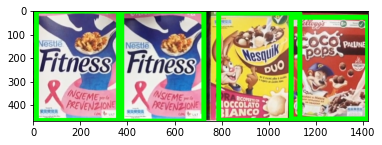

Product 0 - 0 instance/s found:
Product 1 - 0 instance/s found:
Product 11 - 0 instance/s found:
Product 19 - 0 instance/s found:
Product 24 - 2 instance/s found:
	Instance 1 position: (14, 0), width: 349.0px, height: 464.0px
	Instance 2 position: (377, 0), width: 349.0px, height: 467.0px
Product 25 - 1 instance/s found:
	Instance 1 position: (1097, 26), width: 325.0px, height: 432.0px
Product 26 - 1 instance/s found:
	Instance 1 position: (789, 8), width: 345.0px, height: 456.0px
________________________________________________________________________________



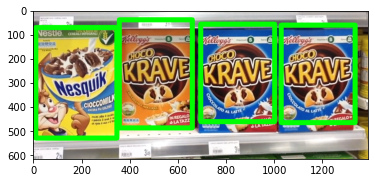

Product 0 - 1 instance/s found:
	Instance 1 position: (11, 72), width: 337.0px, height: 457.0px
Product 1 - 2 instance/s found:
	Instance 1 position: (696, 58), width: 307.0px, height: 403.0px
	Instance 2 position: (1030, 62), width: 307.0px, height: 403.0px
Product 11 - 1 instance/s found:
	Instance 1 position: (358, 40), width: 303.0px, height: 447.0px
Product 19 - 0 instance/s found:
Product 24 - 0 instance/s found:
Product 25 - 0 instance/s found:
Product 26 - 0 instance/s found:
________________________________________________________________________________



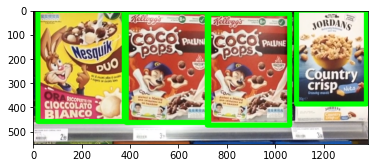

Product 0 - 0 instance/s found:
Product 1 - 0 instance/s found:
Product 11 - 0 instance/s found:
Product 19 - 1 instance/s found:
	Instance 1 position: (1089, 0), width: 289.0px, height: 386.0px
Product 24 - 0 instance/s found:
Product 25 - 2 instance/s found:
	Instance 1 position: (385, 7), width: 341.0px, height: 455.0px
	Instance 2 position: (720, 14), width: 341.0px, height: 459.0px
Product 26 - 1 instance/s found:
	Instance 1 position: (20, 0), width: 357.0px, height: 458.0px
________________________________________________________________________________



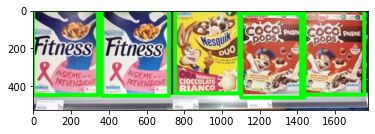

Product 0 - 0 instance/s found:
Product 1 - 0 instance/s found:
Product 11 - 0 instance/s found:
Product 19 - 0 instance/s found:
Product 24 - 2 instance/s found:
	Instance 1 position: (0, 0), width: 344.0px, height: 447.0px
	Instance 2 position: (364, 0), width: 357.0px, height: 451.0px
Product 25 - 2 instance/s found:
	Instance 1 position: (1104, 17), width: 335.0px, height: 443.0px
	Instance 2 position: (1421, 0), width: 335.0px, height: 445.0px
Product 26 - 1 instance/s found:
	Instance 1 position: (753, 0), width: 341.0px, height: 438.0px
________________________________________________________________________________



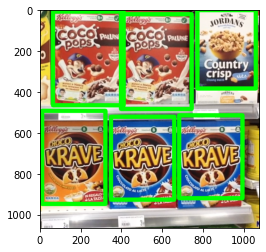

Product 0 - 0 instance/s found:
Product 1 - 2 instance/s found:
	Instance 1 position: (346, 521), width: 309.0px, height: 405.0px
	Instance 2 position: (679, 514), width: 309.0px, height: 405.0px
Product 11 - 1 instance/s found:
	Instance 1 position: (10, 492), width: 309.0px, height: 455.0px
Product 19 - 1 instance/s found:
	Instance 1 position: (768, 0), width: 285.0px, height: 383.0px
Product 24 - 0 instance/s found:
Product 25 - 2 instance/s found:
	Instance 1 position: (63, 7), width: 345.0px, height: 458.0px
	Instance 2 position: (395, 20), width: 345.0px, height: 463.0px
Product 26 - 0 instance/s found:
________________________________________________________________________________



In [20]:
for j in scenes_to_test:
    plt.imshow(cv2.cvtColor(m_final_scene_images_with_bb[j], cv2.COLOR_BGR2RGB))
    plt.show()
    print_result(m_results, j)